In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from decord import VideoReader

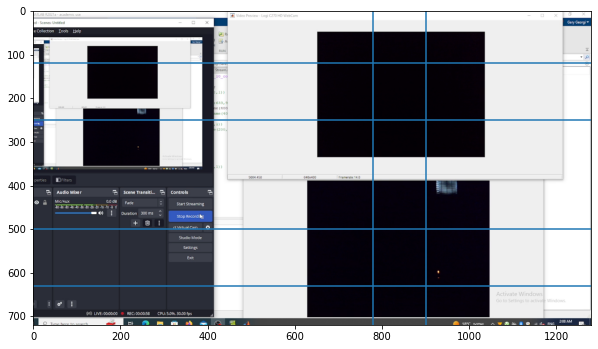

In [53]:
video_path = r"path_to_videos/\A{i}B{j}.mp4"
vr = VideoReader(video_path)
vr.seek(1600)
frame = vr.next()
frame = frame.asnumpy()
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
plt.imshow(frame)
plt.axvline(x=780)
plt.axvline(x=900)

plt.axhline(y=120)
plt.axhline(y=250)

plt.axhline(y=500)
plt.axhline(y=630)
del(vr)


In [9]:
def split_frame_to_cameras(frame):
    top = frame[120:250,780:900, 0]
    bottom = frame[500:630,780:900, 0]
    return top, bottom

In [10]:
start_offset = 1 * 30

In [11]:
vr = VideoReader(video_path)
vr.seek(start_offset)
cal_t, cal_b = [], []
for i in range(30):
    f = vr.next().asnumpy()
    t, b = split_frame_to_cameras(f)
    cal_t.append(t)
    cal_b.append(b)
del(vr)
b_baseline = np.array(cal_b).mean(axis=0)
t_baseline = np.array(cal_t).mean(axis=0)

In [55]:
def detect(arr):
    return arr[arr > np.percentile(arr, 80)].sum()

vr = VideoReader(video_path)
vr.seek(start_offset)
I_t, I_b = [], []
raw_b, raw_t = [], []

for i in range((len(vr)-start_offset)):
    
    raw_b.append(b.sum())
    raw_t.append(t.sum())
    f = vr.next().asnumpy()
    t, b = split_frame_to_cameras(f)
    t, b = t.astype(float), b.astype(float)
    
    raw_b.append(b.sum())
    raw_t.append(t.sum())
    
    t -= t_baseline
    b -= b_baseline
    I_t.append(detect(t))
    I_b.append(detect(b))

del(vr)

<AxesSubplot:>

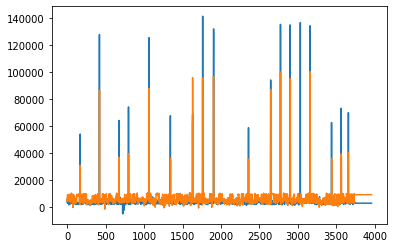

In [13]:
sns.lineplot(I_t)
sns.lineplot(I_b)

In [14]:
def ewma(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def denoise_signal(sig):
    sig = np.array(sig)
#     sig = (sig - sig.min()) / (sig.max() - sig.min())
    return sig - ewma(sig, 200)

In [15]:
t_sig = denoise_signal(I_t)
b_sig = denoise_signal(I_b)

<AxesSubplot:>

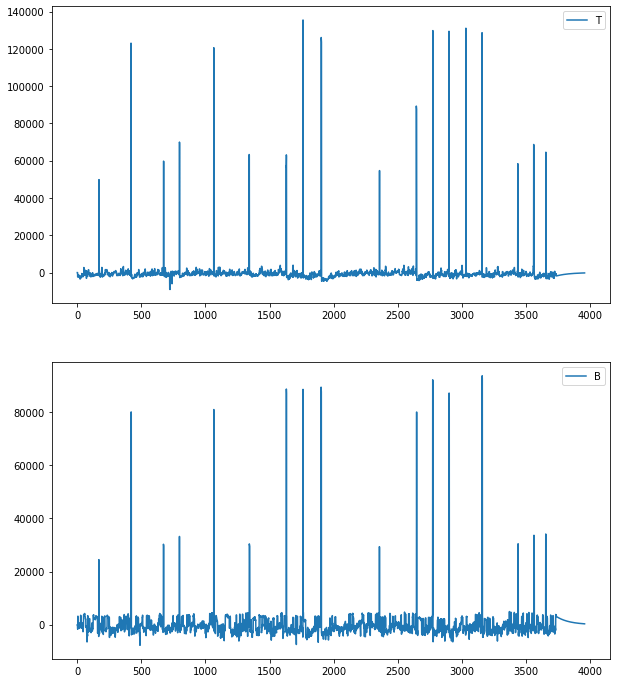

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
# ax1.set_ylim(0, 1)
# ax2.set_ylim(0, 1)

sns.lineplot(t_sig, label="T", ax=ax1)
sns.lineplot(b_sig, label="B", ax=ax2)

In [17]:
top_threshold = 10000#0.15
bottom_threshold = 10000#0.15

t_detections = t_sig > top_threshold

b_detections = b_sig > bottom_threshold

In [ ]:
t_detections.sum()

In [18]:
min_frame_diff = 15
def merge_close_detections(detections, signal):
    # detections: Bool, (num_frames,)
    candidate_frames = np.concatenate((np.where(detections)[0], [0])) # concat [0] in the end to get the final detection as jump
    print(candidate_frames)
    frame_diffs = np.abs(np.ediff1d(candidate_frames))
    jumps = np.argwhere(frame_diffs>min_frame_diff).reshape(-1)
    print(jumps)
    signal_samples = []
    for i in range(jumps.shape[0]):
        start = jumps[i]
        end = jumps[i+1] if i+1 < len(jumps) else len(candidate_frames)
#         frames = candidate_frames[start:end]
        frames = candidate_frames[start]
        signal_samples.append(np.mean(signal[frames]))
    
    clean_signal = np.zeros_like(signal)
    clean_signal[candidate_frames[jumps]] = signal_samples
    return clean_signal

In [19]:
t_clean = merge_close_detections(t_detections, t_sig)
b_clean = merge_close_detections(b_detections, b_sig)

[ 169  170  419  420  673  674  797  798 1065 1341 1342 1629 1630 1631
 1632 1761 1762 1903 1904 1905 2358 2645 2646 2647 2648 2774 2900 3032
 3158 3437 3438 3561 3562 3563 3564 3656 3657    0]
[ 1  3  5  7  8 10 14 16 19 20 24 25 26 27 28 30 34 36]
[ 168  169  420  421  672  673  674  797 1065 1342 1343 1344 1345 1631
 1632 1761 1762 1902 1903 1904 2357 2358 2647 2648 2773 2774 2901 2902
 3159 3160 3439 3440 3563 3564 3565 3655 3656    0]
[ 1  3  6  7  8 12 14 16 19 21 23 25 27 29 31 34 36]


<AxesSubplot:>

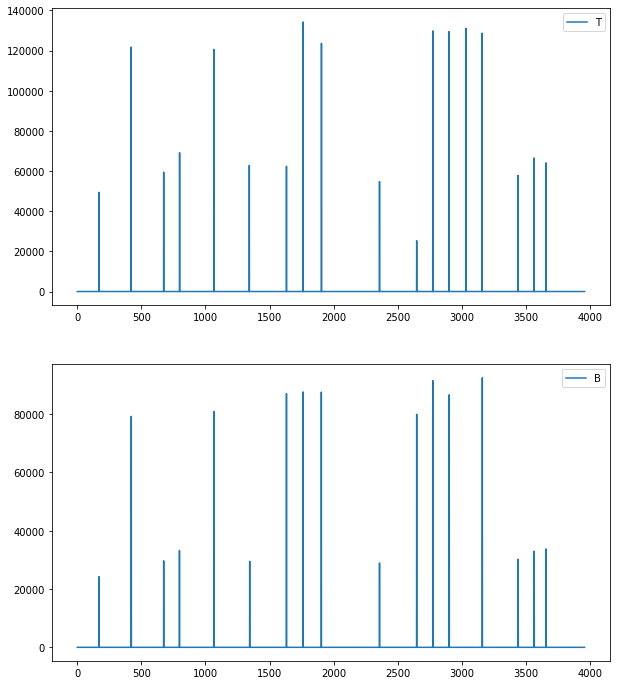

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
# ax1.set_ylim(0, 1)
# ax2.set_ylim(0, 1)

sns.lineplot(t_clean, label="T", ax=ax1)
sns.lineplot(b_clean, label="B", ax=ax2)

In [21]:
def get_simul_signals(t_clean, b_clean, time_diff_threshold=20):
    t_clean_det = np.argwhere(t_clean > 0)
    b_clean_det = np.argwhere(b_clean > 0)

    diff_mat = np.subtract.outer(t_clean_det, b_clean_det).reshape((t_clean_det.shape[0], b_clean_det.shape[0]))

    t_diff_from_b = np.abs(diff_mat).min(axis=1) 
    b_diff_from_t = np.abs(diff_mat).min(axis=0)

    t_simul_det = t_clean_det[t_diff_from_b < time_diff_threshold].reshape(-1)
    b_simul_det = b_clean_det[b_diff_from_t < time_diff_threshold].reshape(-1)

    print(f"t detections: {t_simul_det.shape}, b detections: {b_simul_det.shape}")

    t_simul_sig, b_simul_sig = np.zeros_like(t_clean), np.zeros_like(b_clean)
    t_simul_sig[t_simul_det] = t_clean[t_simul_det]
    b_simul_sig[b_simul_det] = b_clean[b_simul_det]
    return t_simul_sig, b_simul_sig, t_clean[t_simul_det], b_clean[b_simul_det]

In [22]:
t_simul_sig, b_simul_sig, t_meas, b_meas = get_simul_signals(t_clean, b_clean)

t detections: (17,), b detections: (17,)


<AxesSubplot:>

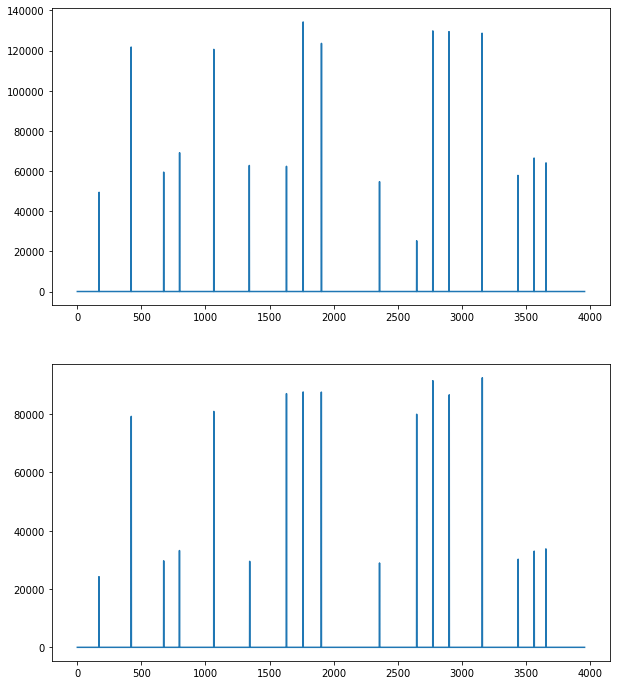

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
# ax1.set_ylim(0, 1)
# ax2.set_ylim(0, 1)

sns.lineplot(t_simul_sig, ax=ax1)
sns.lineplot(b_simul_sig, ax=ax2)

In [24]:
# taken from tomography part, b is BR and t is TL
t_full_flux = 127401
b_full_flux = 126027

In [25]:
b_norm = b_simul_sig / b_full_flux
t_norm = t_simul_sig / t_full_flux

In [47]:
np.argwhere(t_clean>0)

array([[ 170],
       [ 420],
       [ 674],
       [ 798],
       [1065],
       [1342],
       [1632],
       [1762],
       [1905],
       [2358],
       [2648],
       [2774],
       [2900],
       [3032],
       [3158],
       [3438],
       [3564],
       [3657]], dtype=int64)

<AxesSubplot:>

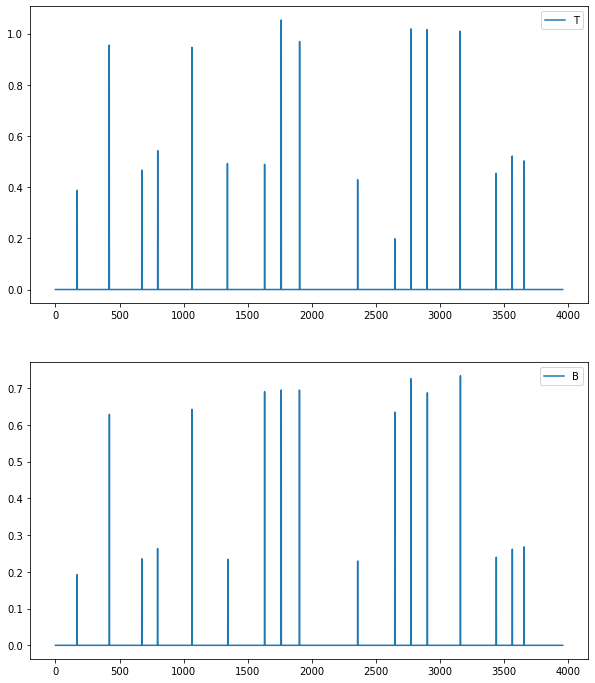

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
# ax1.set_ylim(0, 1)
# ax2.set_ylim(0, 1)

sns.lineplot(t_norm, ax=ax1)
# sns.lineplot(t_norm, label="T", ax=ax1)
# sns.lineplot(b_norm, label="B", ax=ax2)

In [7]:
true_seq = np.array([int(x) for x in "10010111011110000"]).astype(bool)


H_idxs = np.argwhere(true_seq==1)
V_idxs = np.argwhere(true_seq==0)

t_V = t_norm[t_norm>0][V_idxs]
t_H = t_norm[t_norm>0][H_idxs]
b_V = b_norm[b_norm>0][V_idxs]
b_H = b_norm[b_norm>0][H_idxs]

P_VV = (t_V * b_V).mean()
P_HH = (t_H * b_H).mean()

P_VV, P_HH

NameError: name 't_norm' is not defined